# Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [2]:
pd.set_option('display.max_rows', 400) #replace n with the number of rows you want to see completely

# Datasets

In [3]:
aCryptoCurrencies = pd.read_csv('Data\cryptocurrencies.csv')['Symbol'].values

In [4]:
aModelTypes = pd.read_csv('Data\model types.csv')['Model Type'].values

In [5]:
dfOhlc = pd.read_csv('Data\dfOhlc.csv')
dfOhlc['timestamp'] = pd.DatetimeIndex(dfOhlc['timestamp'])
dfOhlc.set_index('timestamp', inplace=True)

# Descriptive Statistics

# Experiments of Full Factorial Design

# Coefficient of Determination of 1st Order Models of 1st Order Models

# Coefficient of Determination of 2nd Order Models

# Bubbe Plot of Steepest Descent Process

# Surface Plot of Grid Search

# Experiments of Central Composite Design

# Optimum Configurations via RSM

# Test Results of Optimum Configurations via RSM

# Average Custom Metrics of Simulation Predictions via DOE

# Multi-Step Comparison of ?????? Simulation

# ___

In [6]:
import Calculate_Metrics
import Optimize_Portfolio

aTimeSteps = list(pd.read_csv('Data/'+ aCryptoCurrencies[0] +'//Simulation//' + 'dfPredictionClose.csv', index_col = 'timestamp').iloc[:, 1:].columns)

decMaximumRisk = 0.25
decInitialBalance = 100

aIxSteps = [
    '2022-03-09 08:30:00', 
    '2022-03-09 10:00:00', 
    '2022-03-09 11:30:00'
]

aSimulationProfits = pd.DataFrame(
    index = aIxSteps,
    columns = ['Expected', 'Realized']
)

decRealizedBalance = decInitialBalance
decExpectedBalance = decInitialBalance
for ixStep in aIxSteps:
    dfExpectedPricesClose = pd.DataFrame(index = aCryptoCurrencies, columns = aTimeSteps)
    dfExpectedPricesOpen = pd.DataFrame(index = aCryptoCurrencies, columns = aTimeSteps)
    dfExpectedSpread = pd.DataFrame(index = aCryptoCurrencies, columns = aTimeSteps)
    dfPredictionError = pd.DataFrame(index = aCryptoCurrencies)

    dfRealizedPricesClose = pd.DataFrame(index = aCryptoCurrencies, columns = aTimeSteps)
    dfRealizedPricesOpen = pd.DataFrame(index = aCryptoCurrencies, columns = aTimeSteps)
    dfRealizedSpread = pd.DataFrame(index = aCryptoCurrencies, columns = aTimeSteps)

    
    for sExchangeRate in aCryptoCurrencies:
        sSimulationFolderPath = 'Data/'+ sExchangeRate +'//Simulation//'
        
        dfPredictionClose = pd.read_csv(sSimulationFolderPath + 'dfPredictionClose.csv', index_col = 'timestamp')
        dfActualClose = pd.read_csv(sSimulationFolderPath + 'dfActualClose.csv', index_col = 'timestamp')
        dfActualTestDataset = pd.read_csv(sSimulationFolderPath + 'dfActualTestDataset.csv', index_col = 'timestamp')
        dfPredictionTestDataset = pd.read_csv(sSimulationFolderPath + 'dfPredictionTestDataset.csv', index_col = 'timestamp')

        dfActualTestDataset = Calculate_Metrics.dfGetCombinationsOfReturns(dfActualTestDataset)
        dfPredictionTestDataset = Calculate_Metrics.dfGetCombinationsOfReturns(dfPredictionTestDataset)

        if len(dfPredictionError.columns) == 0:
            dfPredictionError[list(dfPredictionTestDataset.columns)] = np.nan

        dfExpectedPricesClose.loc[sExchangeRate] = dfPredictionClose.loc[ixStep].iloc[1:].values
        dfExpectedPricesOpen.loc[sExchangeRate] = dfPredictionClose.loc[ixStep].iloc[:-1].values
        dfExpectedSpread.loc[sExchangeRate] = dfOhlc.loc[ixStep, sExchangeRate + ':spread']

        dfRealizedPricesClose.loc[sExchangeRate] = dfActualClose.loc[ixStep].iloc[1:].values
        dfRealizedPricesOpen.loc[sExchangeRate] = dfActualClose.loc[ixStep].iloc[:-1].values
        dfRealizedSpread.loc[sExchangeRate] = dfOhlc.loc[ixStep, sExchangeRate + ':spread']

        dfPredictionError.loc[sExchangeRate] = Calculate_Metrics.fCalculateCustomMetric(dfActualTestDataset, dfPredictionTestDataset, 0)


    dfForwardTimeSteps = pd.DataFrame(aTimeSteps, columns = ['TIME_STEP'])
    dfFinancialProducts = pd.DataFrame(aCryptoCurrencies, columns = ['FINANCIAL_PRODUCT'])

    oPmPrediction = Optimize_Portfolio.PortfolioManagement(dfExpectedPricesClose ,dfExpectedPricesOpen, dfExpectedSpread, dfFinancialProducts , dfForwardTimeSteps, decRealizedBalance, decMaximumRisk, dfPredictionError)
    aAmountsPrediction, aPositionTypesPredictions, dfAlgorithmHistory = oPmPrediction.Main()

    oPmRealized = Optimize_Portfolio.PortfolioManagement(dfRealizedPricesClose ,dfRealizedPricesOpen, dfRealizedSpread, dfFinancialProducts , dfForwardTimeSteps, decRealizedBalance, decMaximumRisk, dfPredictionError)

    fExpectedProfit = oPmPrediction.decEvaluateFitness(aAmountsPrediction, aPositionTypesPredictions)
    fRealizedProfit = oPmRealized.decEvaluateFitness(aAmountsPrediction, aPositionTypesPredictions)
    
    decRealizedBalance = decRealizedBalance + fRealizedProfit
    decExpectedBalance = decExpectedBalance + fExpectedProfit
    
    aSimulationProfits.loc[ixStep, 'Expected'] = fExpectedProfit
    aSimulationProfits.loc[ixStep, 'Realized'] = fRealizedProfit

C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessFunction' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


<AxesSubplot:>

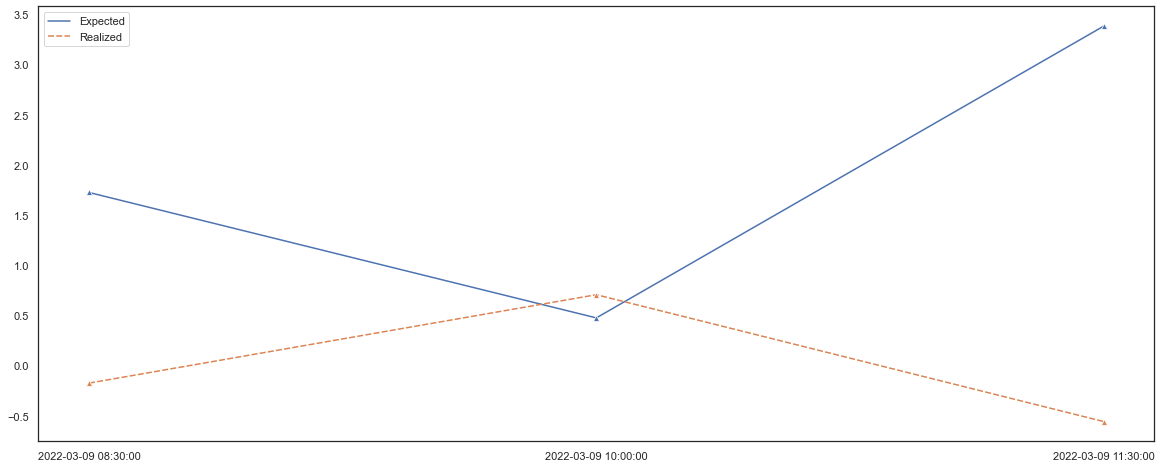

In [7]:
sns.set(rc = {'figure.figsize':(20,8)})
sns.set_style('white')
sns.lineplot(data = aSimulationProfits, marker = '^')